In [1]:
import librosa
# import librosa.display
import IPython.display as ipd
import numpy as np
import os
from matplotlib import pyplot as plt

import sounddevice as sd
from IPython.core.display import display as core_display
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

In [28]:
class Guitar:
    def __init__(self, guitar_path_):
        "Change retreiving string number"
        self.guitar_path = guitar_path_
        self.strings = dict()
        
        print("Loading of guitar has begun")
        for string_path in os.listdir(self.guitar_path):
            string = int(string_path[:string_path.find(" ")])
            self.strings[string] = String(self.guitar_path, string)
            
        print("Loading of guitar was successfully finished")
        
    def get_string(self, string):
        return self.strings[string]
    
class String:
    def __init__(self, guitar_path, string_):
        
        "Change retreiving fret number"
        self.string = string_
        self.frets = dict()
        
        string_path_ = os.path.join(guitar_path, f"{string_} string/")
        self.string_path = string_path_
        
        print(f"Loading of {self.string} string has begun")
        for fret_path in os.listdir(self.string_path):
            fret = int(fret_path[:fret_path.find(" ")])
            self.frets[fret] = Fret(self.string_path, fret)
    
    def get_fret(self, fret):
        return self.frets[fret]
    
    def show_waveforms(self, frets, filtered=True):
        # visualise the waveforms for few or one frets
        
        num_frets = len(frets)
        plt.figure(figsize=(15, num_frets*3))

        for i, fret in enumerate(frets):
            plt.subplot(num_frets, 1, i + 1)
            if filtered:
                librosa.display.waveshow(self.frets[fret].signal_filtered, alpha=0.5)
            else:
                librosa.display.waveshow(self.frets[fret].signal, alpha=0.5)
            plt.title(f"{self.string} string, {fret} fret")
            plt.ylim((-1, 1))

        plt.show()
    
    def show_envelopes(self, frets, frame_size=1024, hop_length=512):
        # visualise the waveforms for few or one frets
        
        plt.figure(figsize=(15, 3))

        for fret in frets:
            if not hasattr(self.frets[fret], "envelope"):
                self.frets[fret].amplitude_envelope(frame_size=1024, hop_length=512)
            
            frames = range(0, self.frets[fret].envelope.size)
            time = librosa.frames_to_time(frames, hop_length=self.frets[fret].hop_length)
            
            plt.plot(time, self.frets[fret].envelope, label=f"{self.string} string, {fret} fret")
        
        plt.legend()
        plt.show()
    
    def show_envelopes_filtered(self, frets, frame_size=1024, hop_length=512):
        # visualise the waveforms for few or one frets
        
        plt.figure(figsize=(15, 3))

        for fret in frets:
            if not hasattr(self.frets[fret], "envelope"):
                self.frets[fret].amplitude_envelope_filtered(frame_size=1024, hop_length=512)
            
            frames = range(0, self.frets[fret].envelope_filtered.size)
            time = librosa.frames_to_time(frames, hop_length=self.frets[fret].hop_length_filtered)
            
            plt.plot(time, self.frets[fret].envelope_filtered, label=f"{self.string} string, {fret} fret")
        
        plt.legend()
        plt.show()
        
        
    
class Fret:
    def __init__(self, string_path, fret):
        self.fret = fret
        
        fret_path = os.path.join(string_path, f"{fret} fret.mp3")
        self.fret_path = fret_path
        
        fret_signal, sr = librosa.load(self.fret_path)
        self.signal = fret_signal
        self.sr = sr
        
        low_bound = max(0, np.argmax(self.signal) - 4000)
        high_bound = min(len(self.signal), np.argmax(self.signal) + 30000)
        self.signal_filtered = self.signal[low_bound: high_bound]
        
    def play_sound(self):
        sd.play(self.signal)
        
    def display(self):
        "Change to display not by using path, but by using signal"
        core_display(ipd.Audio(self.fret_path))
    
    def show_waveform(self):
        # visualise the waveforms for few or one frets
    
        plt.figure(figsize=(18, 3))
        librosa.display.waveshow(self.signal, alpha=0.5)
        plt.show()
        
    def amplitude_envelope(self, frame_size, hop_length):
        amplitude_envelope = list()

        for i in range(0, len(self.signal), hop_length):
            current_frame_amplitude_envelope = max(self.signal[i:i+frame_size])
            amplitude_envelope.append(current_frame_amplitude_envelope)

        self.envelope = np.array(amplitude_envelope)
        self.hop_length = hop_length
        
    def amplitude_envelope_filtered(self, frame_size, hop_length):
        amplitude_envelope = list()

        for i in range(0, len(self.signal_filtered), hop_length):
            current_frame_amplitude_envelope = max(self.signal_filtered[i:i+frame_size])
            amplitude_envelope.append(current_frame_amplitude_envelope)

        self.envelope_filtered = np.array(amplitude_envelope)
        self.hop_length_filtered = hop_length
    
    def calculate_magnitude_spectrum(self):
        ft = np.fft.fft(self.signal_filtered)
        self.magnitude_spectrum = np.abs(ft)
        
    def show_magnitude_spectrum(self, f_ratio=1):
        if not hasattr(self, "magnitude_spectrum"):
            self.calculate_magnitude_spectrum()
        
        # plotting
        plt.figure(figsize=(18, 3))

        frequency = np.linspace(0, self.sr, len(self.magnitude_spectrum))
        num_frequency_bins = int(len(frequency) * f_ratio)

        plt.plot(frequency[:num_frequency_bins], self.magnitude_spectrum[:num_frequency_bins])
        plt.xlabel("frequency")
        plt.title(f"{self.fret} fret")

        plt.show()
        
    def plot_chroma(self):
        chroma = librosa.feature.chroma_stft(y=self.signal)

        note = np.argmax(np.mean(chroma, axis=1))
        notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
        note_name = notes[note]

        plt.figure(figsize=(18, 3))
        librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
        plt.colorbar()
        plt.title(f"{self.fret} fret. Main note = {note_name}")
        plt.tight_layout()
        plt.show()

        return note_name

In [29]:
def plot_chroma_by_signal(signal):
    chroma = librosa.feature.chroma_stft(y=signal)

    note = np.argmax(np.mean(chroma, axis=1))
    notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    note_name = notes[note]

    plt.figure(figsize=(18, 3))
    librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

    return note_name

In [30]:
# guitar = Guitar(guitar_path_="Guitar/")
guitar = Guitar(guitar_path_="data/Guitar/")
guitar.get_string(1).get_fret(0).play_sound()

Loading of guitar has begun
Loading of 5 string has begun
Loading of 6 string has begun
Loading of 1 string has begun
Loading of 3 string has begun
Loading of 2 string has begun
Loading of 4 string has begun
Loading of guitar was successfully finished


In [5]:
fret_signal, sr = librosa.load("data/test.wav")

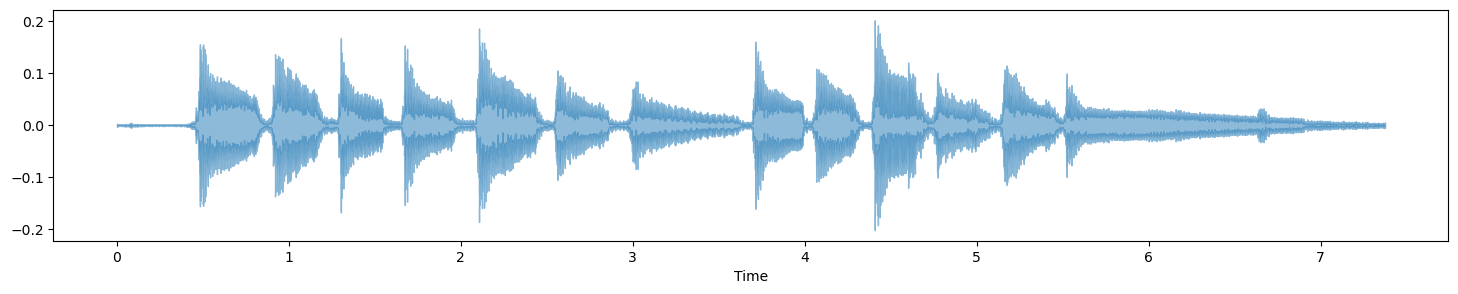

In [6]:
plt.figure(figsize=(18, 3))
librosa.display.waveshow(fret_signal, alpha=0.5)

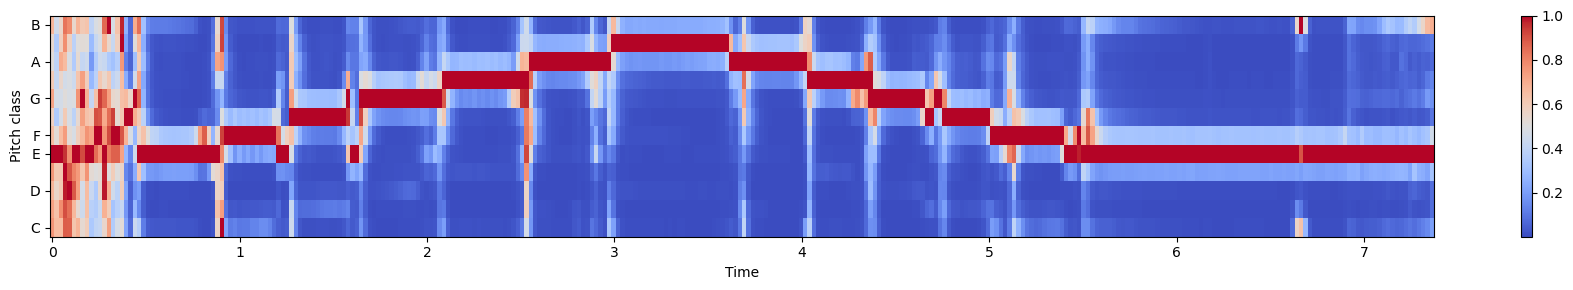

'E'

In [7]:
plot_chroma_by_signal(fret_signal)

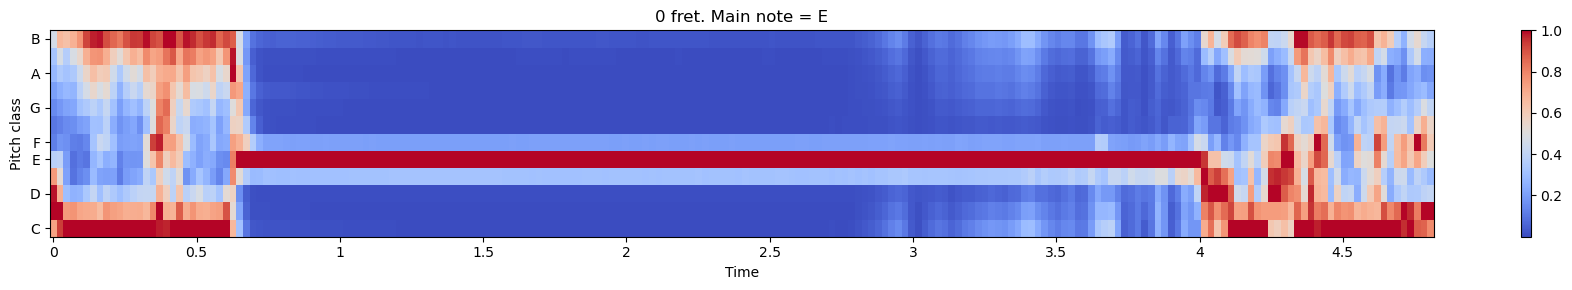

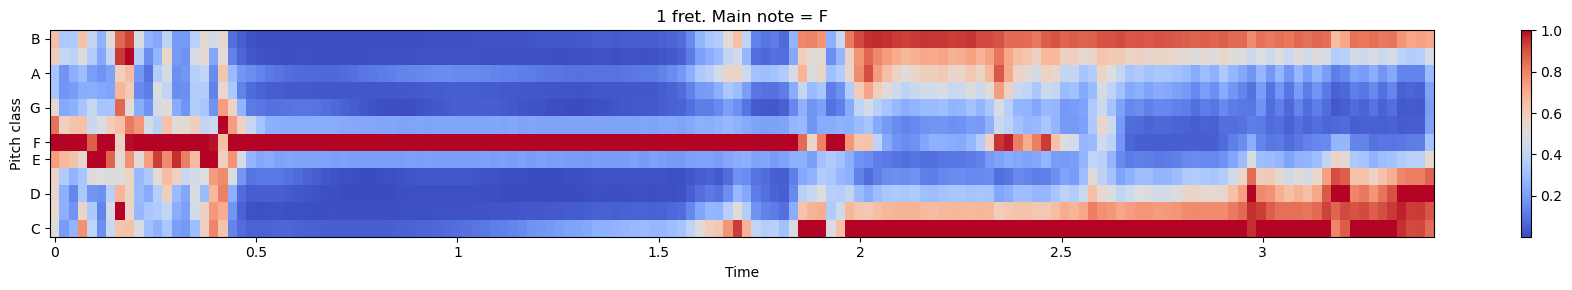

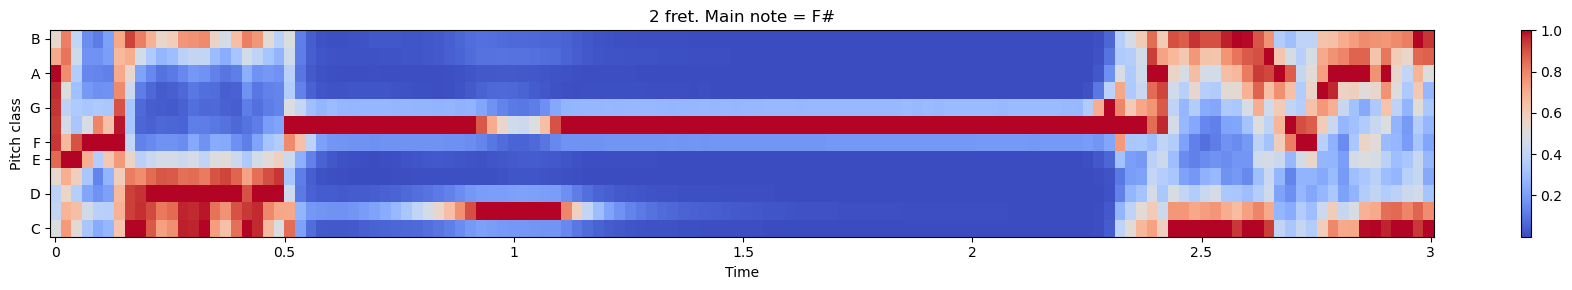

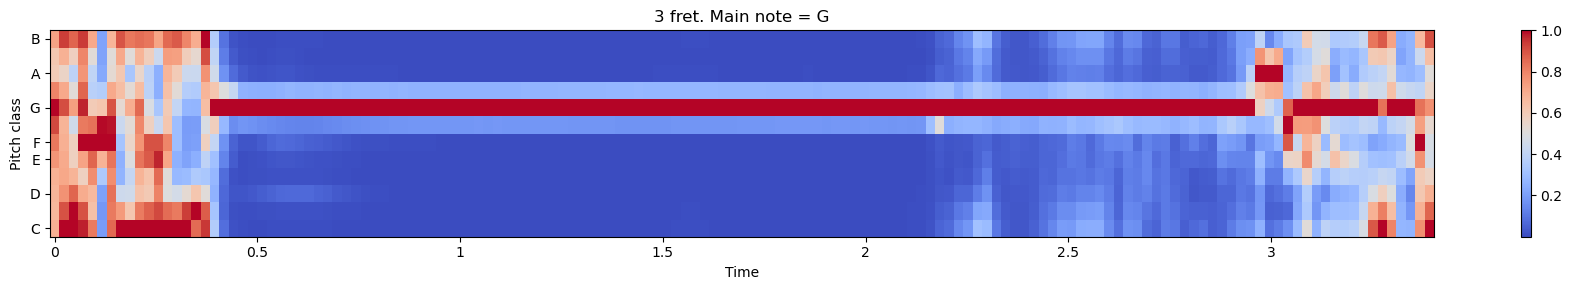

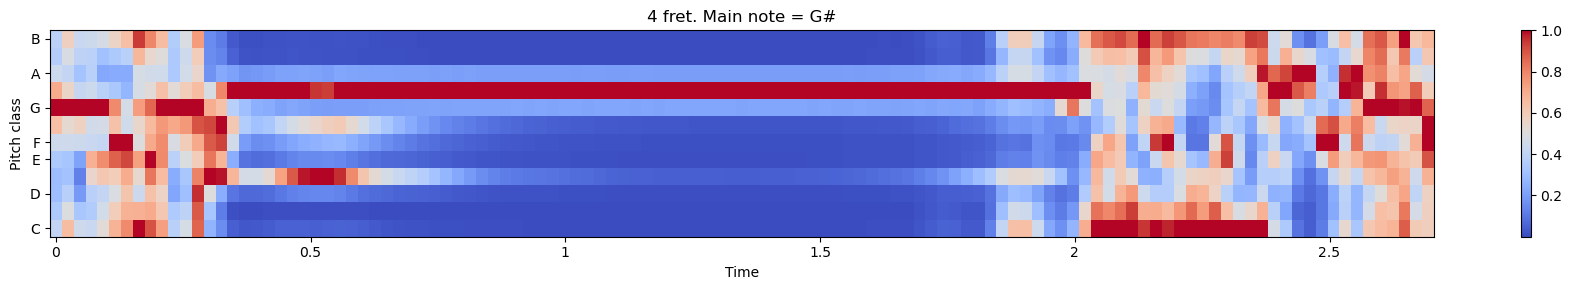

In [31]:
for i in range(5):
    guitar.get_string(1).get_fret(i).plot_chroma()

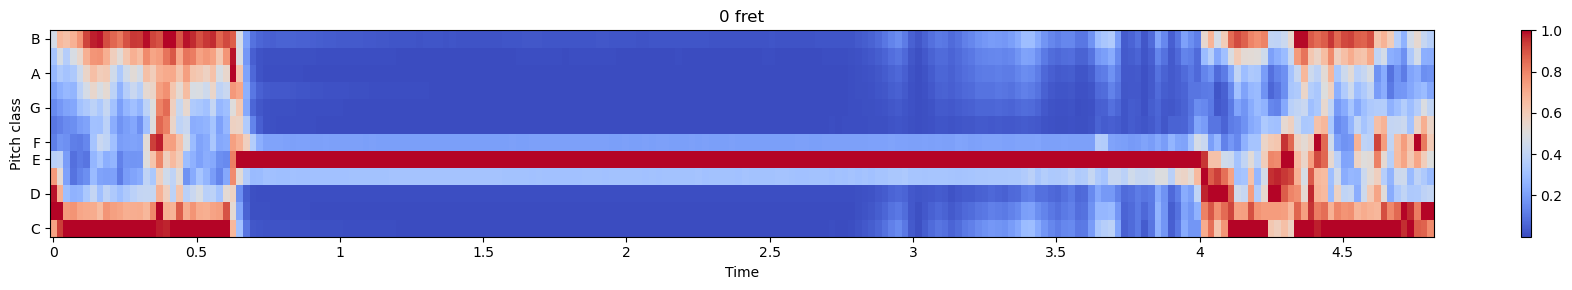

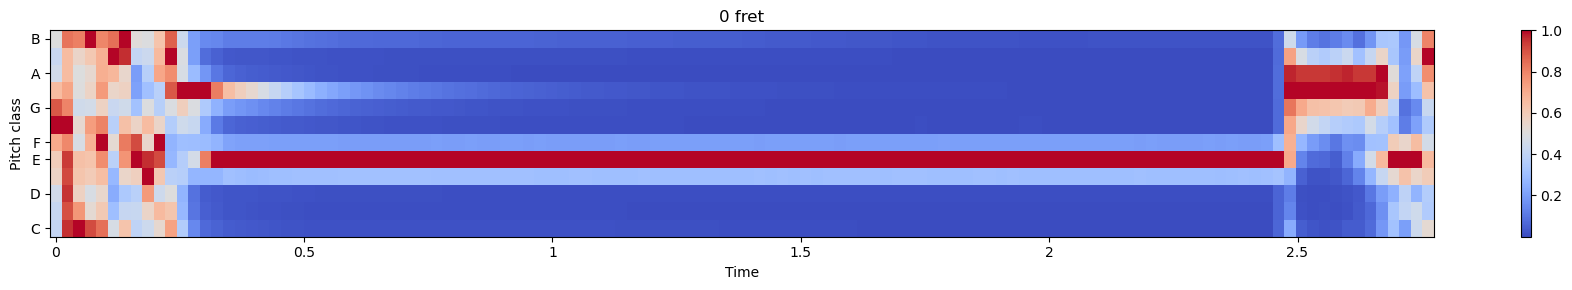

'E'

In [11]:
guitar.get_string(1).get_fret(0).plot_chroma()
guitar.get_string(6).get_fret(0).plot_chroma()

In [61]:
test_fret

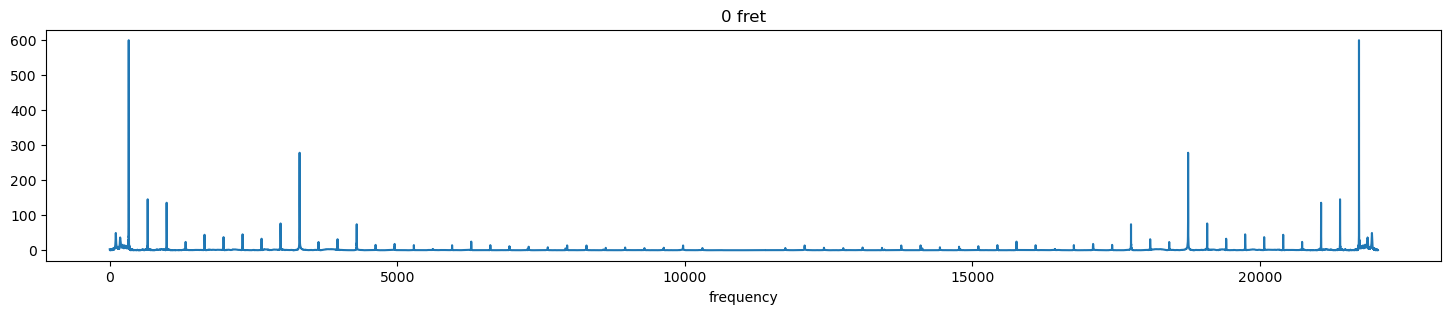

In [24]:
guitar.get_string(6).get_fret(0).show_magnitude_spectrum()

In [16]:
y, sr = guitar.get_string(6).get_fret(0).signal, guitar.get_string(6).get_fret(0).sr

In [17]:
# Compute the chromagram (a 12-element pitch class profile)
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)

# Sum the chroma values across time to get a pitch distribution
pitch_distribution = chroma.sum(axis=1)

# Find the index of the maximum value in the pitch distribution
max_pitch_index = pitch_distribution.argmax()

# Map the pitch index to a frequency using the librosa A4 tuning constant
A4 = librosa.note_to_hz('A4')
frequency = A4 * 2 ** ((max_pitch_index - 9) / 12)

# Check if the frequency corresponds to E4 or E2
if abs(frequency - 329.63) < abs(frequency - 82.41):
    print('The note is closer to E4, which is the first string of a guitar.')
else:
    print('The note is closer to E2, which is the sixth string of a guitar.')


The note is closer to E4, which is the first string of a guitar.


In [20]:
librosa.note_to_hz('E4')

329.6275569128699

In [21]:
librosa.note_to_hz('E2')

82.4068892282175

In [23]:
guitar.get_string(6).get_fret(0).signal

0.27633607

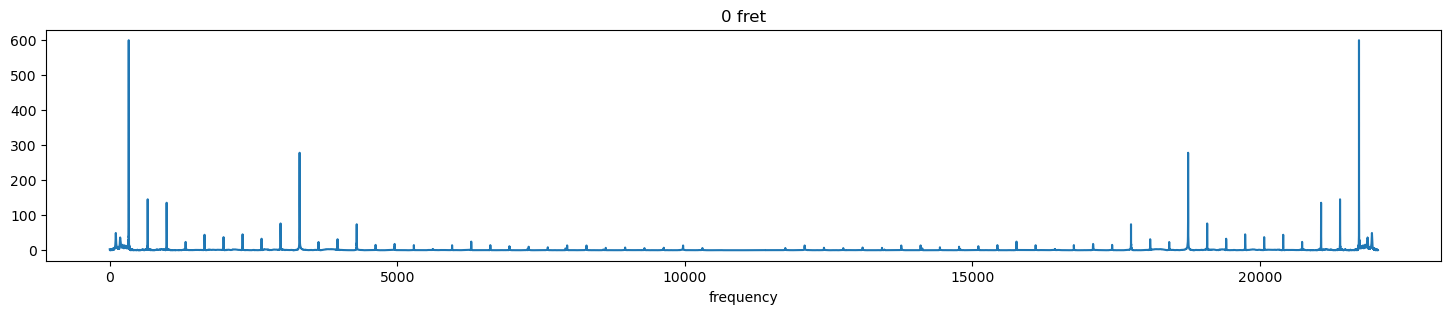

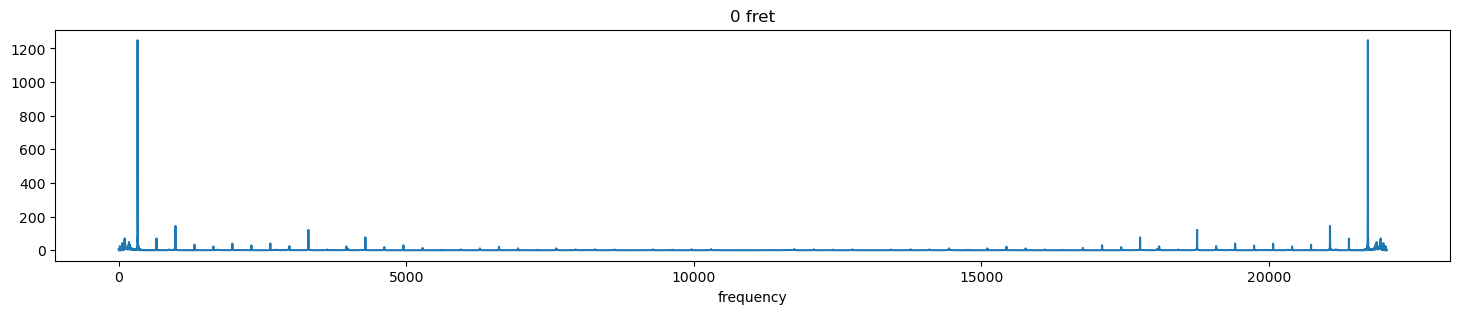

In [27]:
guitar.get_string(6).get_fret(0).show_magnitude_spectrum()
guitar.get_string(1).get_fret(0).show_magnitude_spectrum()

In [26]:
5000/15

333.3333333333333

## Note

In [62]:
y = test_fret.signal
sr = test_fret.sr

In [63]:
chroma = librosa.feature.chroma_stft(y=test_fret.signal)

In [ ]:
chroma = librosa.feature.chroma_stft(y=test_fret.signal)

note = np.argmax(np.mean(chroma, axis=1))
notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
note_name = notes[note]

plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, x_axis='time', y_axis='chroma', cmap='coolwarm')
plt.colorbar()
plt.title('Chromagram of Guitar Audio Sample')
plt.tight_layout()
plt.show()

return note_name

In [1]:
sr = guitar.get_string(1).get_fret(5).sr

NameError: name 'guitar' is not defined

In [58]:
chroma

(12, 208)

In [55]:
frequencies, magnitudes = librosa.core.piptrack(y=y, sr=sr)

# Take the frequency with the highest magnitude as the fundamental frequency
fundamental_frequency = frequencies[np.argmax(magnitudes)]

## Fret

In [72]:
y = test_fret.signal
sr = test_fret.sr

In [95]:
n_fft = 2048
frequencies, magnitudes = librosa.core.piptrack(y=y, sr=sr, n_fft=n_fft)

# Take the frequency with the highest magnitude as the fundamental frequency
fundamental_frequency = frequencies.flatten()[np.argmax(magnitudes)]

In [97]:
open_note = 'E2'
fret_position = 12 * np.log2(fundamental_frequency / librosa.note_to_hz(open_note)) + 1

# Round the fret position to the nearest integer
fret_position = int(round(fret_position))

In [98]:
fret_position

25

In [85]:
np.argmax(magnitudes)

6480

In [ ]:
open_note = 'E2'
fret_position = 12 * np.log2(fundamental_frequency / librosa.note_to_hz(open_note)) + 1

# Round the fret position to the nearest integer
fret_position = int(round(fret_position))


In [46]:
corr = np.fft.ifft(np.fft.fft(chroma) * np.conj(np.fft.fft(open_chroma)))
corr = np.real(corr)
corr /= np.sqrt(np.sum(chroma ** 2) * np.sum(open_chroma ** 2))

In [49]:
lag = np.argmax(corr)
fret = lag / guitar.get_string(1).get_fret(5).sr * 2 ** (1 / 12)

In [50]:
fret

0.04574189867709974

In [57]:

# Load audio signal
y, sr = guitar.get_string(1).get_fret(0).signal, guitar.get_string(1).get_fret(0).sr

In [58]:


# Compute chroma features
chroma = librosa.feature.chroma_cqt(y=y, sr=sr)

# Get the chroma values for the first and sixth strings
chroma_first_string = chroma[5]  # index 5 corresponds to the first string
chroma_sixth_string = chroma[0]  # index 0 corresponds to the sixth string

# Print the most dominant note for each string
print('First string:', librosa.midi_to_note(np.argmax(chroma_first_string)))
print('Sixth string:', librosa.midi_to_note(np.argmax(chroma_sixth_string)))


First string: C♯16
Sixth string: A11


In [60]:
np.mean(chroma, axis=1)

array([0.3870028 , 0.2599035 , 0.17733994, 0.12926234, 0.6880251 ,
       0.19354723, 0.21122   , 0.10907553, 0.12860578, 0.15294783,
       0.39630082, 0.5450172 ], dtype=float32)

In [62]:
import librosa
import numpy as np

# Load audio signal
y, sr = librosa.load('path/to/audio/file')

# Compute chroma features
chroma = librosa.feature.chroma_stft(y=y, sr=sr)

# Find the most dominant pitch class for a given note
note_idx = 0  # Example: find the octave of the first note in the chroma features
pitch_class = np.argmax(chroma[note_idx])

# Compute the fundamental frequency of the pitch class in standard tuning
standard_tuning_freq = librosa.note_to_hz('E2')  # The E2 note is the open sixth string
fundamental_freq = standard_tuning_freq * 2**(pitch_class / 12)

# Compute the harmonic product spectrum
D = np.abs(librosa.stft(y))**2
hps = D.copy()
for h in range(2, 5):
    hps *= np.abs(librosa.stft(y, n_fft=int(sr * (1/h))))**2
hps = np.sqrt(hps)

# Find the frequency bin that corresponds to the pitch of the note
freqs = librosa.fft_frequencies(sr=sr, n_fft=len(D))
note_freq = librosa.note_to_hz(librosa.midi_to_note(12 * np.log2(freqs/440) + 69))[pitch_class]
note_bin = np.argmin(np.abs(freqs - note_freq))

# Compute the octave of the note
ratio = freqs[note_bin] / fundamental_freq
octave = int(np.log2(ratio))
print(f'The octave of the note is {octave}')


ValueError: operands could not be broadcast together with shapes (1025,208) (5513,39) (1025,208) 